# Make ACTN2 Affimer PERPL analysis plots

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import modelling_general
import plotting
import zdisk_modelling
import zdisk_plots

## Set average estimated localisation precision for Affimer and PALM data.
This is the mean after filtering for localisation precision < 5 nm.

In [2]:
af647_precision = 3.1 # Mean value after filtering for precision < 5 nm

## Set standard maximum distance over which to plot distances and fit models.

In [3]:
fitlength = 100.

## Choose Affimer relative position data and combine files if necessary
### Insert paths to the Affimer relative position data here:

In [4]:
actn_affimer_relpos_path = r"..\data-perpl\ACTN2-Affimer_PERPL-relpos_200.0filter_len2440488.pkl"

### Select desired datasets to combine here:
These contain all data attributes, including the relative positions in both directions for each pair of localisations. We will filter e.g. for cell-axial data later.

In [5]:
path_list = [actn_affimer_relpos_path]
print(path_list)
relpos = zdisk_modelling.read_relpos_from_pickles(path_list)

['..\\data-perpl\\ACTN2-Affimer_PERPL-relpos_200.0filter_len2440488.pkl']


### Data attributes and number of data points:

In [6]:
relpos.iloc[0, :] # This shows the first relative position.

axial          49.426791
perpaxis2D     34.358846
tocoverslip    15.602947
z_nzcorr       16.072208
transverse     37.932126
Name: 0, dtype: float64

In [7]:
len(relpos) # This shows how many relative positions.

2440488

## Get the axial (X) distances, without duplicates
The YZ-distance limit for pairs of localisations to include can be set here.

In [ ]:
# This is the YZ-distance limit for X-distances to include:
transverse_limit = 10.

axial_distances = zdisk_modelling.getaxialseparations_no_smoothing(
    relpos,
    max_distance=relpos.axial.max(),
    transverse_limit=transverse_limit
    )
axial_distances = zdisk_modelling.remove_duplicates(axial_distances)

## Get the 1-nm bin histogram data
Up to distance = fitlength

In [ ]:
hist_values, bin_edges = zdisk_plots.plot_distance_hist(
    axial_distances,
    fitlength
    )
bin_centres = (bin_edges[0:(len(bin_edges) - 1)]
               + bin_edges[1:]
               ) / 2

## Get the KDE data
Estimate every 1 nm, with kernel size based on localisation precision estimate.

In [ ]:
kde_x_values, kde = zdisk_plots.plot_distance_kde(
    axial_distances,
    af647_precision,
    100.
    )

## Calculate the axial RPD with smoothing for Churchman 1D function

In [ ]:
calculation_points = np.arange(fitlength + 1.)
axial_rpd = plotting.estimate_rpd_churchman_1d(
    input_distances=axial_distances,
    calculation_points=calculation_points,
    combined_precision=(np.sqrt(2) * af647_precision)
)
plt.plot(calculation_points, axial_rpd)

## Choose axial model:

In [ ]:
axial_model_with_info = zdisk_modelling.set_up_model_4_peaks_fixed_ratio_with_fit_settings()


## Fit model to histogram bin values, at bin centres

In [ ]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    bin_centres,
    hist_values,
    axial_model_with_info.model_rpd,
    axial_model_with_info.initial_params,
    axial_model_with_info.param_bounds,
    )
print('')
print('Initial parameter guesses:')
print(axial_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(axial_model_with_info.param_bounds)

## Plot fitted model over histogram data

In [32]:
fig, axes = zdisk_plots.plot_distance_hist_and_fit(
    axial_distances,
    fitlength,
    params_optimised,
    params_covar,
    axial_model_with_info
)

NameError: name 'axial_distances' is not defined

## Plot fitted model over histogram data, with confidence intervals on the model
### NOTE: IT TAKES A WHILE TO CALCULATE THE CONFIDENCE INTERVALS
### Skip this if you don't need it right now.

In [ ]:
zdisk_plots.plot_distance_hist_and_fit(
    axial_distances,
    fitlength,
    params_optimised,
    params_covar,
    axial_model_with_info,
    plot_95ci=True
)

## Akaike weights for the models
Typed in AICc values for the different models here, to obtain relative likelihood, summing to one:

In [ ]:
from modelstats import akaike_weights
weights = akaike_weights([
    364.35,
    364.51,
    366.38,
    370.28,
    374.67
])
print(weights)

## Plot model components for best model (4 peaks with fixed peak ratio)

In [ ]:
zdisk_plots.plot_model_components_4peaks_fixed_peak_ratio(
    fitlength,
    *params_optimised)

# Transverse distances

## Get the transverse (YZ) distances, without duplicates
The X-distance limit for pairs of localisations to include can be set here.

In [8]:
# This is the YZ-distance limit for X-distances to include:
axial_limit = 10.
print(relpos.shape)

trans_distances = zdisk_modelling.get_transverse_separations(
    relpos,
    max_distance=relpos.transverse.max(),
    axial_limit=axial_limit
    )
trans_distances = zdisk_modelling.remove_duplicates(trans_distances)

(2440488, 5)


## Choose analysis lengthscale for transverse distance

In [9]:
fitlength = 50.

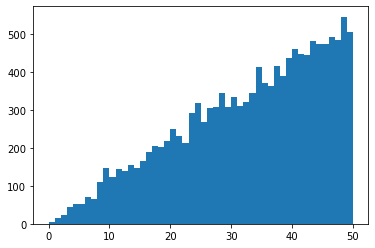

In [10]:
hist_1nm_bins = plt.hist(trans_distances, bins=np.arange(fitlength + 1.))

## Estimate RPD using Churchman's function

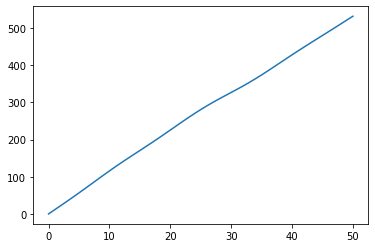

In [11]:
fitlength = 50.
calculation_points = np.arange(fitlength + 1.)
combined_precision= np.sqrt(2) * af647_precision
transverse_rpd = plotting.estimate_rpd_churchman_2d(
    input_distances=trans_distances[trans_distances < (fitlength + 3 * combined_precision)],
    calculation_points=calculation_points,
    combined_precision=combined_precision
)
plt.plot(calculation_points, transverse_rpd)

## Normalise for increasing search circle with increasing distance

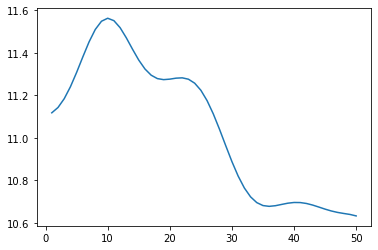

In [12]:
normalised_transverse_rpd = transverse_rpd[calculation_points > 0.] / calculation_points[calculation_points > 0.]
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]
plt.plot(norm_rpd_calculation_points, normalised_transverse_rpd)

### 1 nm-bin  histogram result for comparison

In [ ]:
plt.plot(hist_1nm_bins[1][0:-1] + 0.5, hist_1nm_bins[0]/(hist_1nm_bins[1][0:-1] + 0.5))

### Optional save/load to save time

In [ ]:
np.save('normalised_transverse_rpd_smoothed_Churchman-4p4', normalised_transverse_rpd)
# normalised_transverse_rpd = np.load('normalised_transverse_rpd_smoothed_Churchman-4p4.npy')

## Set up an RPD model and fit
I've tried a few smoothing kernel widths here.

In [ ]:
trans_model_with_info = zdisk_modelling.set_up_model_2d_onepeak_plus_replocs_flat_bg_with_fit_settings()

In [ ]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

In [ ]:
plt.plot(norm_rpd_calculation_points,
    normalised_transverse_rpd)
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points,
    fitlength,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=False
    )

In [15]:
fitlength = 50.
calculation_points = np.arange(fitlength + 1.)
combined_precision=8.
transverse_rpd_s8 = plotting.estimate_rpd_churchman_2d(
    input_distances=trans_distances[trans_distances < (fitlength + 3 * combined_precision)],
    calculation_points=calculation_points,
    combined_precision=combined_precision
)

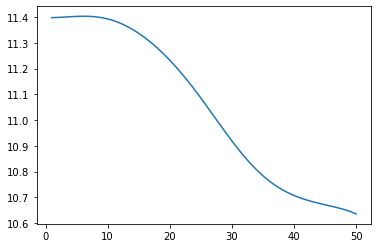

In [20]:
normalised_transverse_rpd_s8 = transverse_rpd_s8[calculation_points > 0.] / calculation_points[calculation_points > 0.]
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]
plt.plot(norm_rpd_calculation_points, normalised_transverse_rpd_s8)
np.save('..\data-perpl\ACTN2-Affimer\\normalised_transverse_rpd_smoothed_Churchman-8', normalised_transverse_rpd_s8)
# normalised_transverse_rpd = np.load('normalised_transverse_rpd_smoothed_Churchman-4p4.npy')

In [ ]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s8[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

In [ ]:
plt.plot(norm_rpd_calculation_points,
    normalised_transverse_rpd_s8)
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points,
    fitlength,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=False
    )

In [21]:
fitlength = 50.
calculation_points = np.arange(fitlength + 1.)
combined_precision=5.
transverse_rpd_s5 = plotting.estimate_rpd_churchman_2d(
    input_distances=trans_distances[trans_distances < (fitlength + 3 * combined_precision)],
    calculation_points=calculation_points,
    combined_precision=combined_precision
)

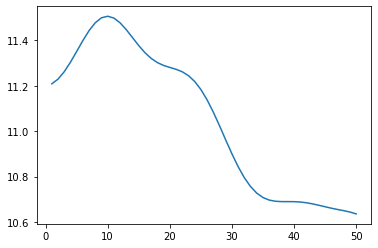

In [22]:
normalised_transverse_rpd_s5 = transverse_rpd_s5[calculation_points > 0.] / calculation_points[calculation_points > 0.]
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]
plt.plot(norm_rpd_calculation_points, normalised_transverse_rpd_s5)
np.save('normalised_transverse_rpd_smoothed_Churchman-5', normalised_transverse_rpd_s5)
# normalised_transverse_rpd = np.load('normalised_transverse_rpd_smoothed_Churchman-4p4.npy')

In [23]:
fitlength = 50.
calculation_points = np.arange(fitlength + 1.)
combined_precision=6.
transverse_rpd_s6 = plotting.estimate_rpd_churchman_2d(
    input_distances=trans_distances[trans_distances < (fitlength + 3 * combined_precision)],
    calculation_points=calculation_points,
    combined_precision=combined_precision
)

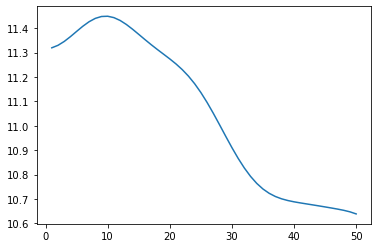

In [24]:
normalised_transverse_rpd_s6 = transverse_rpd_s6[calculation_points > 0.] / calculation_points[calculation_points > 0.]
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]
plt.plot(norm_rpd_calculation_points, normalised_transverse_rpd_s6)
np.save('normalised_transverse_rpd_smoothed_Churchman-6', normalised_transverse_rpd_s6)
# normalised_transverse_rpd = np.load('normalised_transverse_rpd_smoothed_Churchman-4p4.npy')

In [ ]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s6[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

In [ ]:
plt.plot(norm_rpd_calculation_points,
    normalised_transverse_rpd_s8)
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points,
    fitlength,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=False
    )

## Set up another model and fit
Tried a few smoothing widths again
### This model fits much better

In [25]:
trans_model_with_info = zdisk_modelling.set_up_model_2d_twopeaks_flat_bg_with_fit_settings()

In [26]:
normalised_transverse_rpd_s6 = np.load('./normalised_transverse_rpd_smoothed_Churchman-6.npy')
calculation_points = np.arange(fitlength + 1.)
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]

In [27]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s6[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

[[1.10972642e+01 8.35992331e-03]
 [2.38092488e+01 2.03679789e-02]
 [6.59552871e+00 7.85793535e-03]
 [1.20984124e+02 4.88657166e-01]
 [1.84130391e+02 8.07139153e-01]
 [1.06337374e+01 1.97937077e-03]]
SSR = 3.1998682683694416e-06
AIC = -484.67803170839477
AICcorr = -479.80846649100346

Initial parameter guesses:
[20, 40.0, 5, 1, 1, 20]

Parameter bounds:
([0, 0, 0, 0, 0, 0], [50, 50.0, 20, 1000, 1000, 100])


x at zero bg is -0.05775112568529942.


C:\Code\perpl-python3\models_2d_distances_normalised.py:101: RuntimeWarning: invalid value encountered in double_scalars
  / x_values # Normalisation
C:\Code\perpl-python3\models_2d_distances_normalised.py:104: RuntimeWarning: invalid value encountered in double_scalars
  / x_values # Normalisation
C:\Users\fbsacu\Miniconda3\envs\PERPL\lib\site-packages\numdifftools\extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
C:\Users\fbsacu\Miniconda3\envs\PERPL\lib\site-packages\numdifftools\limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
C:\Users\fbsacu\Miniconda3\envs\PERPL\lib\site-packages\numdifftools\limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
C:\Users\fbsacu\Miniconda3\envs\PERPL\lib\site-packages\numdifftools\limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der <

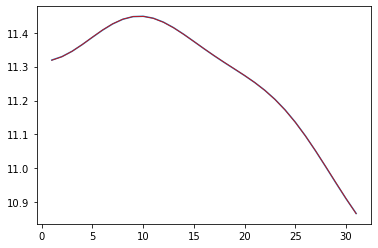

In [28]:
plt.plot(norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s6[0:31])
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points[0:31],
    31.,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=True
    )

In [ ]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

In [ ]:
plt.plot(norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd[0:31])
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points[0:31],
    31.,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=True
    )

In [ ]:
normalised_transverse_rpd_s8 = np.load('./normalised_transverse_rpd_smoothed_Churchman-8.npy')
calculation_points = np.arange(fitlength + 1.)
norm_rpd_calculation_points = calculation_points[calculation_points > 0.]

In [ ]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s8[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

In [ ]:
plt.plot(norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s8[0:31])
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points[0:31],
    31.,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=True
    )

In [30]:
(params_optimised,
 params_covar,
 params_1sd_error) = zdisk_modelling.fitmodel_to_hist(
    norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s5[0:31],
    trans_model_with_info.model_rpd,
    trans_model_with_info.initial_params,
    trans_model_with_info.param_bounds
    )
print('')
print('Initial parameter guesses:')
print(trans_model_with_info.initial_params)
print('')
print('Parameter bounds:')
print(trans_model_with_info.param_bounds)

[[1.11603027e+01 1.30711725e-02]
 [2.40419243e+01 3.66960752e-02]
 [5.80236918e+00 1.55535221e-02]
 [1.28784895e+02 1.16939837e+00]
 [1.99900011e+02 2.28218321e+00]
 [1.05942593e+01 5.64415618e-03]]
SSR = 5.0241686788911083e-05
AIC = -399.31223265322444
AICcorr = -394.44266743583313

Initial parameter guesses:
[20, 40.0, 5, 1, 1, 20]

Parameter bounds:
([0, 0, 0, 0, 0, 0], [50, 50.0, 20, 1000, 1000, 100])


x at zero bg is -0.05299779236206779.


C:\Code\perpl-python3\models_2d_distances_normalised.py:101: RuntimeWarning: invalid value encountered in double_scalars
  / x_values # Normalisation
C:\Code\perpl-python3\models_2d_distances_normalised.py:104: RuntimeWarning: invalid value encountered in double_scalars
  / x_values # Normalisation
C:\Users\fbsacu\Miniconda3\envs\PERPL\lib\site-packages\numdifftools\extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
C:\Users\fbsacu\Miniconda3\envs\PERPL\lib\site-packages\numdifftools\limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
C:\Users\fbsacu\Miniconda3\envs\PERPL\lib\site-packages\numdifftools\limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
C:\Users\fbsacu\Miniconda3\envs\PERPL\lib\site-packages\numdifftools\limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der <

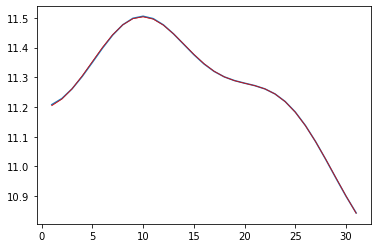

In [31]:
plt.plot(norm_rpd_calculation_points[0:31],
    normalised_transverse_rpd_s5[0:31])
zdisk_plots.plot_fitted_model(
    norm_rpd_calculation_points[0:31],
    31.,
    params_optimised,
    params_covar,
    trans_model_with_info,
    plot_95ci=True
    )